#Preprocess
In the preprocess of the project, I split the slides in two parts: the first part is train and validation set, which is used to train the model, and the second part is the test set, which is used to show the result of the model. 
Then, I use a sliding window to extract the patches from the slides in the train and validation part in two different level: level 2 and level 3, and save the images in the google drive for the next step.


## Setup

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import shutil
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (139 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
!ls '/content/gdrive/MyDrive/slides1'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [ ]:
# Read WSI
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# File paths
slides_root = '/content/gdrive/MyDrive/slides1'
tumor_slides = 'tumor_110.tif'
tumor_mask_slides = 'tumor_110_mask.tif'
tumor_url = os.path.join(slides_root, tumor_slides)
tumor_mask_url = os.path.join(slides_root, tumor_mask_slides)
# tumor
tumor = open_slide(tumor_url)
tumor_mask = open_slide(tumor_mask_url)
print(tumor.level_dimensions[0][0], tumor.level_dimensions[0][1])
print(tumor_mask.level_dimensions[0][0], tumor_mask.level_dimensions[0][1])
for i in range(len(tumor.level_dimensions)):
  print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             tumor.level_dimensions[i], 
                                                             tumor.level_downsamples[i]))
  print(tumor.level_dimensions[i][0], tumor.level_dimensions[i][1])

94208 71680
94208 71680
Level 0, dimensions: (94208, 71680) downsample factor 1
94208 71680
Level 1, dimensions: (47104, 35840) downsample factor 2
47104 35840
Level 2, dimensions: (23552, 17920) downsample factor 4
23552 17920
Level 3, dimensions: (11776, 8960) downsample factor 8
11776 8960
Level 4, dimensions: (5888, 4480) downsample factor 16
5888 4480
Level 5, dimensions: (2944, 2240) downsample factor 32
2944 2240
Level 6, dimensions: (1472, 1120) downsample factor 64
1472 1120
Level 7, dimensions: (736, 560) downsample factor 128
736 560
Level 8, dimensions: (368, 280) downsample factor 256
368 280


##Find valid slides and split

There are some invalid slides in the dataset, so find the valid slides first. Then, get the tumor percentage of each slides, then split the slides into two parts: one is used to train model and the other one is used to test the model and show the result of the model.

In [ ]:
# Get all validate files from directory
root = '/content/gdrive/MyDrive/slides1'
filepath = sorted(os.listdir(root))
final_file_path = []
number = ["{0:03}".format(i) for i in range(111)]
for i in number:
  if "tumor_" + i + ".tif" not in filepath:
    continue
  if "tumor_" + i + "_mask.tif" not in filepath:
    continue
  if "tumor_" + i + ".xml" not in filepath:
    continue
  final_file_path.append(["tumor_" + i + ".tif", "tumor_" + i + "_mask.tif", "tumor_" + i + ".xml"])
print(final_file_path)

[['tumor_001.tif', 'tumor_001_mask.tif', 'tumor_001.xml'], ['tumor_002.tif', 'tumor_002_mask.tif', 'tumor_002.xml'], ['tumor_005.tif', 'tumor_005_mask.tif', 'tumor_005.xml'], ['tumor_012.tif', 'tumor_012_mask.tif', 'tumor_012.xml'], ['tumor_016.tif', 'tumor_016_mask.tif', 'tumor_016.xml'], ['tumor_019.tif', 'tumor_019_mask.tif', 'tumor_019.xml'], ['tumor_023.tif', 'tumor_023_mask.tif', 'tumor_023.xml'], ['tumor_031.tif', 'tumor_031_mask.tif', 'tumor_031.xml'], ['tumor_035.tif', 'tumor_035_mask.tif', 'tumor_035.xml'], ['tumor_057.tif', 'tumor_057_mask.tif', 'tumor_057.xml'], ['tumor_059.tif', 'tumor_059_mask.tif', 'tumor_059.xml'], ['tumor_064.tif', 'tumor_064_mask.tif', 'tumor_064.xml'], ['tumor_075.tif', 'tumor_075_mask.tif', 'tumor_075.xml'], ['tumor_078.tif', 'tumor_078_mask.tif', 'tumor_078.xml'], ['tumor_081.tif', 'tumor_081_mask.tif', 'tumor_081.xml'], ['tumor_084.tif', 'tumor_084_mask.tif', 'tumor_084.xml'], ['tumor_091.tif', 'tumor_091_mask.tif', 'tumor_091.xml'], ['tumor_094.t

In [ ]:
# Get tumor percentage of each tumor
level = 5
for filepath in final_file_path:
  tumor_mask_slides = filepath[1]
  tumor_mask_url = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_mask_slides)
  tumor_mask = open_slide(tumor_mask_url)
  mask = read_slide(tumor_mask, 
                     x = 0, 
                     y = 0,
                     level = level, 
                     width = tumor_mask.level_dimensions[level][0], 
                     height = tumor_mask.level_dimensions[level][1])
  mask = mask[:, :, 0]
  percentage = sum(sum(mask == 1)) / (tumor_mask.level_dimensions[level][0] * tumor_mask.level_dimensions[level][1]) * 100
  if percentage < 0.01:
    continue
  print("The percentage of {} is {:.2f}%".format(filepath[0], percentage))
  

The percentage of tumor_001.tif is 0.05%
The percentage of tumor_005.tif is 0.01%
The percentage of tumor_016.tif is 0.74%
The percentage of tumor_019.tif is 0.02%
The percentage of tumor_031.tif is 0.58%
The percentage of tumor_064.tif is 0.62%
The percentage of tumor_075.tif is 0.68%
The percentage of tumor_078.tif is 9.28%
The percentage of tumor_084.tif is 0.58%
The percentage of tumor_091.tif is 1.45%
The percentage of tumor_094.tif is 0.53%
The percentage of tumor_096.tif is 0.25%
The percentage of tumor_101.tif is 1.92%
The percentage of tumor_110.tif is 15.59%


In the split step, I try several times to split them and I found the way to get the best performance is select more balanced percentage of each tumor and avoid that tumor percentage of some slides is much larger than the others.

In [ ]:
# I select 078, 091 and 110 as the test set and select the percentage larger than 0.1 slides as train set.
Train_set = [['tumor_001.tif', 'tumor_001_mask.tif', 'tumor_001.xml'], 
            ['tumor_005.tif', 'tumor_005_mask.tif', 'tumor_005.xml'], 
            ['tumor_012.tif', 'tumor_012_mask.tif', 'tumor_012.xml'], 
            ['tumor_016.tif', 'tumor_016_mask.tif', 'tumor_016.xml'], 
            ['tumor_019.tif', 'tumor_019_mask.tif', 'tumor_019.xml'], 
            ['tumor_023.tif', 'tumor_023_mask.tif', 'tumor_023.xml'],
            ['tumor_031.tif', 'tumor_031_mask.tif', 'tumor_031.xml'], 
            ['tumor_057.tif', 'tumor_057_mask.tif', 'tumor_057.xml'], 
            ['tumor_064.tif', 'tumor_064_mask.tif', 'tumor_064.xml'], 
            ['tumor_075.tif', 'tumor_075_mask.tif', 'tumor_075.xml'], 
            ['tumor_081.tif', 'tumor_081_mask.tif', 'tumor_081.xml'],
            ['tumor_084.tif', 'tumor_084_mask.tif', 'tumor_084.xml'], 
            ['tumor_094.tif', 'tumor_094_mask.tif', 'tumor_094.xml'], 
            ['tumor_101.tif', 'tumor_101_mask.tif', 'tumor_101.xml']]

Test_set = [['tumor_078.tif', 'tumor_078_mask.tif', 'tumor_078.xml'],
            ['tumor_091.tif', 'tumor_091_mask.tif', 'tumor_091.xml'],
            ['tumor_110.tif', 'tumor_110_mask.tif', 'tumor_110.xml']]

In [ ]:
# get the validate percentage of a image
def tissue_pixels_percentage(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percentage = len(tissue_pixels) / float(image.shape[0] * image.shape[0])
    return percentage

###Show Some slides and the location of tumor

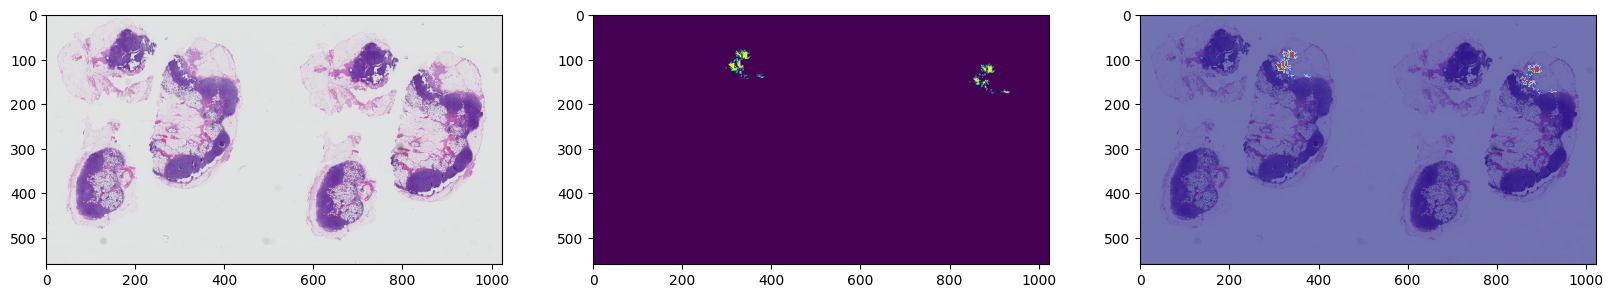

In [ ]:
# Show image 
def myImageShow(tumor, mask_tumor):
  plt.figure(figsize=(20,20), dpi=100)
  plt.subplot(131)
  plt.imshow(tumor)
  plt.subplot(132)
  plt.imshow(mask_tumor)
  plt.subplot(133)
  plt.imshow(tumor)
  plt.imshow(mask_tumor, cmap = "jet", alpha = 0.5)
  plt.show()
 
  
tumor_slides = 'tumor_096.tif'
tumor_mask_slides = 'tumor_096_mask.tif'
tumor_dir = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_slides)
tumor_mask_dir = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_mask_slides)
slide = open_slide(tumor_dir)
slide_mask = open_slide(tumor_mask_dir)
tumor = read_slide(slide, 
                     x = 0, 
                     y = 0,
                     level = 7, 
                     width = slide.level_dimensions[7][0], 
                     height = slide.level_dimensions[7][1])
mask_tumor = read_slide(slide_mask, 
                          x = 0, 
                          y = 0,
                          level = 7, 
                          width = slide.level_dimensions[7][0], 
                          height = slide.level_dimensions[7][1])
mask_tumor = mask_tumor[:, :, 0]
myImageShow(tumor, mask_tumor)

### Using a sliding window to extract the patches from slides

In [ ]:
# Extract Validate Image From a Slide
def extract_patch_from_slides(slide, mask_slide, patch_size, level):
  global tumor_count
  global non_tumor_count
  print("Extracting {}".format(slide))
  tumor_root = "/content/gdrive/MyDrive/{}/tumor".format("level_" + str(level))
  non_tumor_root = "/content/gdrive/MyDrive/{}/no_tumor".format("level_" + str(level))
  tumor_slide = open_slide(slide)
  tumor_mask_slide = open_slide(mask_slide)
  width = tumor_slide.level_dimensions[level][0]
  height = tumor_slide.level_dimensions[level][1]
  x_num = height // patch_size
  y_num = width // patch_size
  factor = 2 ** level
  center = (patch_size - 128) // 2
  for i in range(y_num):
    for j in range(x_num):
      region = read_slide(tumor_slide, x = i * factor * patch_size, y = j * factor * patch_size, level = level, width = patch_size, height = patch_size)
      if tissue_pixels_percentage(region) < 0.2:
        continue
      region_mask = read_slide(tumor_mask_slide, x = i * factor * patch_size, y = j * factor * patch_size, level = level, width = patch_size, height = patch_size)[:,:,0]
      center_region_mask = region_mask[center: center + 128, center: center + 128]
      if np.any(center_region_mask == 1):
        region = Image.fromarray(region)
        region.save(os.path.join(tumor_root, "tumor_{}.png".format(str(tumor_count))), "png")
        tumor_count += 1
      else:
        region = Image.fromarray(region)
        region.save(os.path.join(non_tumor_root, "no_tumor_{}.png".format(str(non_tumor_count))), "png")
        non_tumor_count += 1
  print("Finish Extracting {}. Got {} tumor image and {} non-tumor image".format(slide, tumor_count, non_tumor_count))

###Extract Patches from Slides in level 2

In [ ]:
# Extract image in level 2
patch_size = 299
level = 2
tumor_root = "/content/gdrive/MyDrive/{}/tumor".format("t2level_" + str(level))
non_tumor_root = "/content/gdrive/MyDrive/{}/no_tumor".format("t2level_" + str(level))
level_image_root = "/content/gdrive/MyDrive/{}".format("t2level_" + str(level))
if not os.path.exists(level_image_root):
  os.mkdir(level_image_root)
if not os.path.exists(tumor_root):
  os.mkdir(tumor_root)
if not os.path.exists(non_tumor_root):
  os.mkdir(non_tumor_root)
tumor_count = 1
non_tumor_count = 1
for filepath in Train_set:
  tumor_slides = filepath[0]
  tumor_mask_slides = filepath[1]
  slide = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_slides)
  mask_slide = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_mask_slides) 
  extract_patch_from_slides(slide, mask_slide, patch_size, level)

Extracting /content/gdrive/MyDrive/slides1/tumor_001.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_001.tif. Got 16 tumor image and 1739 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_005.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_005.tif. Got 19 tumor image and 2627 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_012.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_012.tif. Got 22 tumor image and 3742 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_016.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_016.tif. Got 159 tumor image and 4595 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_019.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_019.tif. Got 165 tumor image and 5278 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_023.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_023.tif. Got 170 tumor image and 6244 non-tumor image
E

###Extract Patches from Slides in level 3

In [ ]:
# Extract image in level 3
patch_size = 299
level = 3
tumor_root = "/content/gdrive/MyDrive/{}/tumor".format("level_" + str(level))
non_tumor_root = "/content/gdrive/MyDrive/{}/no_tumor".format("level_" + str(level))
level_image_root = "/content/gdrive/MyDrive/{}".format("level_" + str(level))
if not os.path.exists(level_image_root):
  os.mkdir(level_image_root)
if not os.path.exists(tumor_root):
  os.mkdir(tumor_root)
if not os.path.exists(non_tumor_root):
  os.mkdir(non_tumor_root)
tumor_count = 1
non_tumor_count = 1
for filepath in Train_set:
  tumor_slides = filepath[0]
  tumor_mask_slides = filepath[1]
  slide = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_slides)
  mask_slide = '/content/gdrive/MyDrive/slides1/{}'.format(tumor_mask_slides) 
  extract_patch_from_slides(slide, mask_slide, patch_size, level)

Extracting /content/gdrive/MyDrive/slides1/tumor_001.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_001.tif. Got 6 tumor image and 448 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_005.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_005.tif. Got 8 tumor image and 635 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_012.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_012.tif. Got 8 tumor image and 900 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_016.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_016.tif. Got 47 tumor image and 1077 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_019.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_019.tif. Got 48 tumor image and 1217 non-tumor image
Extracting /content/gdrive/MyDrive/slides1/tumor_023.tif
Finish Extracting /content/gdrive/MyDrive/slides1/tumor_023.tif. Got 51 tumor image and 1440 non-tumor image
Extracting